# LSTM을 사용하여 IMDB 영화 리뷰 데이터 긍/부정 분류하기

In [80]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data import get_tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)

# Torchtext vs Torch.utils

데이터를 불러오는 Dataset 선택지는 크게 두가지가 있다.

1. torchtext.data.Dataset을 사용하는 방법

    장점 : field함수로 자동적으로 Vocab을 생성해준다. 즉, 간편함

    단점 : 현재 지원중단

    교재 코드 동작 방식  - Field로 객체 생성 build_vocab으로 Vocab생성

2. torch.utils.data.Dataset을 사용하는 방법

    장점 : 주로 쓰이는 방법 , 코드 간단

    단점 : 직접 작성해야 한다. (특히 MLM , NSP은 직접 구현해야한다. [참고 - BERT구현 블로그](https://inhyeokyoo.github.io//project/nlp/bert-issue/))

torchtext버전을 내리는 방법동 있지만 개인적으로 선호하지 않음.

결론, torchtext는 Vocab 및 제공하는 Dataset이 있어 편리하지만 개인적으로 사용하고 싶진 않다!


In [81]:
# torchtext에서 제공하는 dataset format
from torchtext.datasets import IMDB

imdb_data = IMDB(split='train')
for a, b in imdb_data:
    print(a,b)
    break

# label , text
# 1은 nagtive / 2는 positive

# 이방법 사용 X

1 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [100]:
# RNN방법과 같이 Dataloader 만들기

# 텍스트 데이터 전처리
review_list = []
label_list = []
for mode in ['train','test']:
    for label in ['pos', 'neg']:
        for fname in tqdm(os.listdir(f'./aclImdb/{mode}/{label}/')):
            if 'txt' not in fname:
                continue
            with open(os.path.join(f'./aclImdb/{mode}/{label}/', fname), encoding="utf8") as f:
                review_list += [f.read()] 
                label_list += [label]

# torchtext의 tokenizer불러오기 = 자동으로 소문자화 , 구두점 분리
tokenizer = get_tokenizer("basic_english")
review_list = [tokenizer(review) for review in review_list]

#review_list = [review.lower() for review in review_list]    
review_list = [' '.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

####################################################################

reviews_blob = ' '.join(review_list)
review_words = reviews_blob.split()
count_words = Counter(review_words)


######### 추가 부분 #####################
from torchtext.vocab import vocab
from collections import OrderedDict # 입력된 순서를 보장 함 ex) dict.items()

#sorted_review_words = count_words.most_common(total_review_words) 원래코드 , 아래와 동일 코드
sorted_review_words = sorted(count_words.items(), key=lambda x: x[1], reverse=True)


ordered_dict = OrderedDict(sorted_review_words)

# torchtext의 vocab 클래스로 Vocab만들기
torchtext_vocab = vocab(ordered_dict  ,specials=['<pad>','<unk>'])
torchtext_vocab.set_default_index(1)
print(f'Vocab.size:{len(torchtext_vocab)}')

# 토크나이저 안쓰면 181687개 최종성능 87 / 77 /79
# 토크나이저 쓰면 147127개 85 / 79 / 78

100%|██████████| 50000/50000 [00:00<00:00, 50192.20it/s]


Vocab.size:147127


In [102]:
# 만들어진 Vocab 테스트
print(f'단어 the : {torchtext_vocab["the"]}, 단어 and : {torchtext_vocab["and"]}')
print(f'단어 <pad> : {torchtext_vocab["<pad>"]}, 단어 <unk> : {torchtext_vocab["<unk>"]}')
print(f'존재하지 않는 단어 : {torchtext_vocab["파이토치"]}')

for i,a in enumerate(torchtext_vocab.get_itos()[:10]):
    print(f'({a}:{i})' , end=" ")

단어 the : 2, 단어 and : 3
단어 <pad> : 0, 단어 <unk> : 1
존재하지 않는 단어 : 1
(<pad>:0) (<unk>:1) (the:2) (and:3) (a:4) (of:5) (to:6) (is:7) (it:8) (in:9) 

In [103]:
# 데이터 로더 만들기

# 리뷰 텍스트 정수화
reviews_tokenized = []
for review in review_list:
    word_to_token = [torchtext_vocab[word] for word in review.split()]   # 위에서 정의한 딕셔너리로 해당 word에 맞는 정수로 변환
    reviews_tokenized.append(word_to_token)

# 레이블 정수화
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]


reviews_len = [len(review) for review in reviews_tokenized]
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32') 

# 리뷰당 단어 개수 시각화
def pad_sequence(reviews_tokenized, sequence_length):
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review    # 패딩+단어
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]    # 길이에 짜름
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

######### 추가 ##################
np.random.seed(42)
indices = np.arange(len(padded_reviews))
np.random.shuffle(indices)

# 랜덤하게 섞인 인덱스를 사용하여 데이터와 라벨을 섞음
padded_reviews = padded_reviews[indices]
encoded_label_list = encoded_label_list[indices]

# train/val/test 나누기 2:1:1

train_X = padded_reviews[:int(0.5*len(padded_reviews))]
train_y = encoded_label_list[:int(0.5*len(padded_reviews))]
validation_X = padded_reviews[int(0.5*len(padded_reviews)):int(0.75*len(padded_reviews))]
validation_y = encoded_label_list[int(0.5*len(padded_reviews)):int(0.75*len(padded_reviews))]
test_X = padded_reviews[int(0.75*len(padded_reviews)):]
test_y = encoded_label_list[int(0.75*len(padded_reviews)):]



# 데이터셋 생성
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))
test_dataset = TensorDataset(torch.from_numpy(test_X).to(device), torch.from_numpy(test_y).to(device))


# 데이터 로더 생성
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# RNN의 문제점

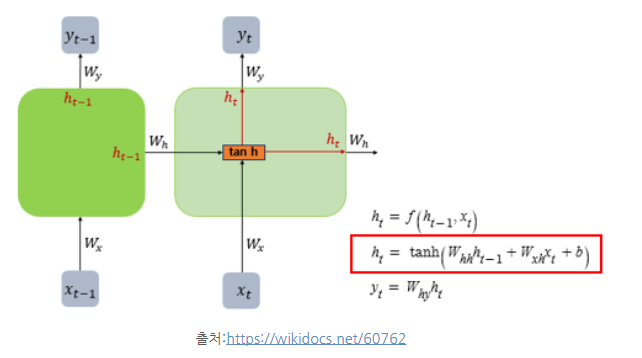

RNN의 문제점은 정해진 가중치로 새로운 input을 기존의 hidden과 곱함 => 곱연산은 그래디언트 소실 야기(0으로 수렴)

# LSTM 이란? 

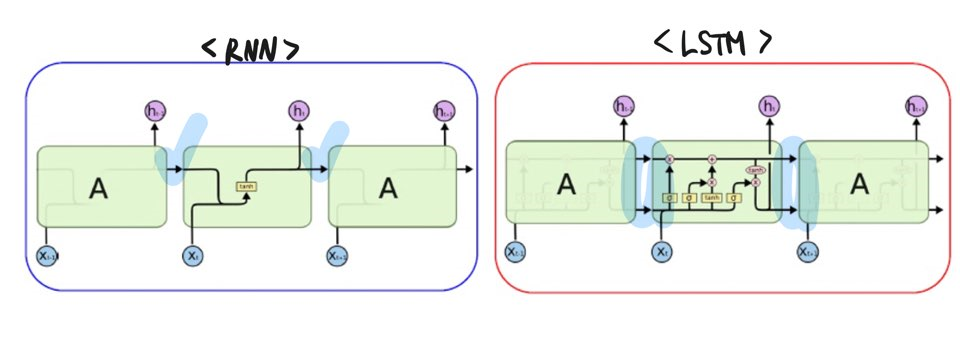

output , hidden = RNN() 

output , hidden , cell = LSTM()

hidden의 shape는 (batch , sequence_length , hidden_D) == cell의 shape

hidden은 short-term memory // cell은 logn-term memory [참고](https://blog.naver.com/winddori2002/221992543837)

# Bi-LSTM

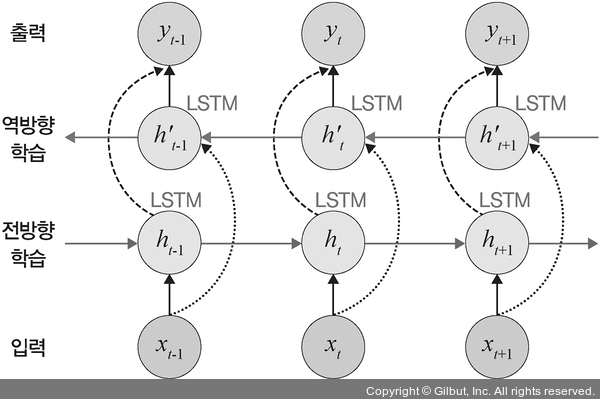

따라서 hidden도 두개 나옴

# Stacked LSTM

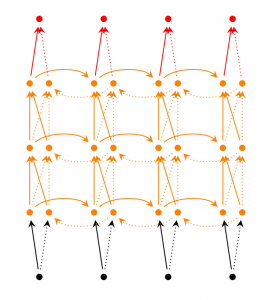

In [104]:
# LSTM 모델 정의
# 책의 ??? page의 cuda_pack_padded_sequence 함수는 Batch 중 가장 긴 길이로 패딩하는 함수라 패스

class LSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension, hidden_dimension, output_dimension, dropout, pad_index):
        super().__init__()
        
        # word => Embedding vector(100차원)
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_dimension, padding_idx = pad_index)

        """
            Embedding_dimension : input x에 차원 , 여기선 word vector차원
            hidden_dimension : hidden_state의 차원 , 여기선 32차원
            num_layer : LSTM을 stacking하는 수 
        """
        self.lstm_layer = nn.LSTM(embedding_dimension, 
                           hidden_dimension, 
                           num_layers=1, 
                           bidirectional=True, 
                           dropout=dropout)
        self.fc_layer = nn.Linear(hidden_dimension * 2, output_dimension)
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, sequence):
        # sequence := (sequence_length, batch_size)

        embedded_output = self.dropout_layer(self.embedding_layer(sequence))
        # embedded_output := (sequence_length, batch_size, embedding_dimension)
        
        packed_output, (hidden_state, cell_state) = self.lstm_layer(embedded_output)
        # hidden_state := (num_layers * num_directions, batch_size, hidden_dimension)
        # cell_state := (num_layers * num_directions, batch_size, hidden_dimension)
        
        #op, op_lengths = nn.utils.rnn.pad_packed_sequence(packed_output) # output은 사용안함
        # op := (sequence_length, batch_size, hidden_dimension * num_directions)
        
        hidden_output = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)       
        # hidden_output := (batch_size, hidden_dimension * num_directions)
        
        return self.fc_layer(hidden_output) # (batch , 1)
        

    
INPUT_DIMENSION = len(torchtext_vocab)
EMBEDDING_DIMENSION = 100
HIDDEN_DIMENSION = 32
OUTPUT_DIMENSION = 1
DROPOUT = 0.5
PAD_INDEX = torchtext_vocab['<pad>']

lstm_model = LSTM(INPUT_DIMENSION, 
            EMBEDDING_DIMENSION, 
            HIDDEN_DIMENSION, 
            OUTPUT_DIMENSION, 
            DROPOUT, 
            PAD_INDEX)

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [105]:
UNK_INDEX = torchtext_vocab['<unk>']

lstm_model.embedding_layer.weight.data[UNK_INDEX] = torch.zeros(EMBEDDING_DIMENSION)
lstm_model.embedding_layer.weight.data[PAD_INDEX] = torch.zeros(EMBEDDING_DIMENSION)

In [106]:
optim = torch.optim.Adam(lstm_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

lstm_model = lstm_model.to(device)
loss_func = loss_func.to(device)

In [107]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [108]:
def train(model, data_iterator, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for x , y in data_iterator:
        optim.zero_grad()
        preds = lstm_model(x.T).squeeze(1)
        
        loss_curr = loss_func(preds, y)
        accuracy_curr = accuracy_metric(preds, y)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(data_iterator), accuracy/len(data_iterator)

In [109]:
def validate(model, data_iterator, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for x , y in data_iterator:
            preds = model(x.T).squeeze(1)

            loss_curr = loss_func(preds, y)
            accuracy_curr = accuracy_metric(preds, y)
    
            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(data_iterator), accuracy/len(data_iterator)

In [110]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(lstm_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(lstm_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(lstm_model.state_dict(), 'lstm_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 3.9470975399017334s
training loss: 0.685 | training accuracy: 54.68%
validation loss: 0.642 |  validation accuracy: 63.10%

epoch number: 2 | time elapsed: 3.6028125286102295s
training loss: 0.612 | training accuracy: 66.74%
validation loss: 0.629 |  validation accuracy: 70.08%

epoch number: 3 | time elapsed: 3.5688135623931885s
training loss: 0.541 | training accuracy: 73.43%
validation loss: 0.780 |  validation accuracy: 65.04%

epoch number: 4 | time elapsed: 3.611907720565796s
training loss: 0.490 | training accuracy: 77.39%
validation loss: 0.830 |  validation accuracy: 66.20%

epoch number: 5 | time elapsed: 3.5907044410705566s
training loss: 0.442 | training accuracy: 80.07%
validation loss: 0.667 |  validation accuracy: 74.04%

epoch number: 6 | time elapsed: 3.588207483291626s
training loss: 0.412 | training accuracy: 81.86%
validation loss: 0.687 |  validation accuracy: 74.48%

epoch number: 7 | time elapsed: 3.600278854370117s
training loss: 

In [114]:
#lstm_model.load_state_dict(torch.load('../../mastering_pytorch_packt/04_deep_recurrent_net_architectures/lstm_model.pt'))
lstm_model.load_state_dict(torch.load('lstm_model.pt'))

test_loss, test_accuracy = validate(lstm_model, test_dataloader, loss_func)

print(f'test loss: {test_loss:.3f} | test accuracy: {test_accuracy*100:.2f}%')

test loss: 0.587 | test accuracy: 78.70%


In [115]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    tokenizer = get_tokenizer("basic_english")
    tokenized = tokenizer(sentence)
    tokenized = [torchtext_vocab[t] for t in tokenized]
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [116]:
print(sentiment_inference(lstm_model, "This film is horrible"))
print(sentiment_inference(lstm_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(lstm_model, "Decent movie, although could be shorter"))
print(sentiment_inference(lstm_model, "This film will be houseful for weeks"))
print(sentiment_inference(lstm_model, "I loved the movie, every part of it"))

0.05133145675063133
0.06564375758171082
0.061424970626831055
0.6344364881515503
0.8859354853630066


# 어텐션

[wikidocs](https://wikidocs.net/22893)

<Dot - product Attention>

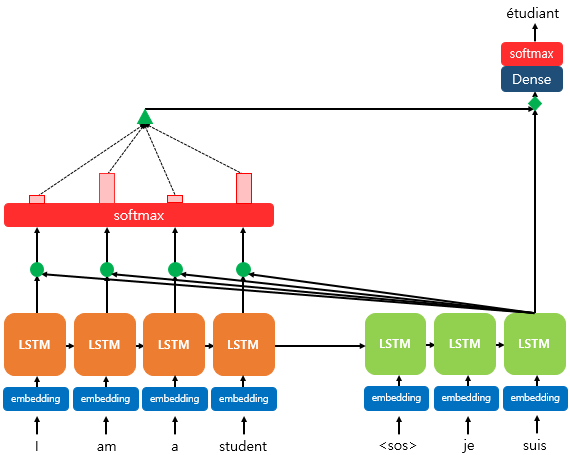

1. 어텐션 스코어 구한다.

    인코더의 각 히든 값 과 디코더의 T시점의 히든 값 내적 (H_e.T내적 H_d) => 내적은 유사도

    디코더가 없으면 Context vector로 사용(최종 Hidden vector)

2. 어텐션 분포 구하기

    Softmax 함수로 각 확률의 합이 1이되도록 Attention 중요도(확률,분포)을 구하기

3. 원래 인코더의 히든 값에 Attention 분포를 가중합하여 Attention Value구하기. 

    원래 히든 값 중 중요한 히든 값은 커지고 덜 중요한 히든 값은 작아짐. => weighted sum하여 원래 히든 크기로 만듦

4. 디코더의 T시점의 히든과 Concatenate

    원래 히든 차원 * 2 가 됨.

5. 두배가 된 hidden을 FC-layer로 입력

    원래는 FC-layer에 들어가기 전에 tanh(linear(2*hidden V))

    FC-layer에 들어가면 분류의 경우 긍/부정 판별 , 디코더의 경우 단어 생성

